<a href="https://colab.research.google.com/github/pierrickBERTHE/Projet9_OCR_DataScientist/blob/main/Berthe_Pierrick_1_notebook_052024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:SteelBlue'>P9 - Réalisez un traitement dans un environnement Big Data sur le Cloud</span>

![Logo Fruits]()

# <span style='background:red; color:black'>MAJ à faire</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

**Etape 1 : Importation des données**

Conclusion

# <span style='background:blue'>Introduction</span>

L'entreprise "Fruits!" est une jeune entreprise qui a la volonté de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruit en développant des robots cueilleurs intelligents.

Pour cela, l'entreprise souhaite se faire connaitre en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit. Le developpement de cette application nécessite un traitement Big Data pour la reconnaissance d'image.
___
**Missions**

1/ Expliquer pas-à-pas le script PySpark implémenté avec :
- Un traitement de diffusion des poids du modèle Tensorflow sur les clusters (broadcast des « weights » du modèle)

- Une étape d’une réduction de dimension de type ACP en PySpark

2/ Faire une démonstration de la mise en place d’une instance EMR opérationnelle.

3/ Démontrer le respect des contraintes RGPD (serveurs situés sur le territoire européen).

4/ Donner mon retour critique sur cette solution (utile avant de la généraliser).
___

**Source des datasets**<br>
Ce jeux de données comporte des images de fruits pour train et test un modèle de reconnaissance d'image.

Nombre d'images : 90_483<br>
Nombre de classes : 131<br>
Taille des images : 100x100 pixels<br>

3 dossiers :
- Training (67_692 images)
- Test (22_688 images)
- test-multiple_fruits


Source : [Fruits-360 dataset](https://www.kaggle.com/datasets/moltean/fruits) sur Kaggle.com<br>

# <span style='background:grey'>Importations des librairies</span>

Liste des imports généraux :

In [27]:
!pip install Pandas pillow tensorflow pyspark pyarrow pyngrok

In [28]:
# Librairies generales
import os
import os.path
import sys
import time
from datetime import datetime
import glob

# Librairies data science
import pandas as pd
from PIL import Image
import numpy as np
import io
import matplotlib as mpl
import matplotlib.pyplot as plt

# Librairies TensorFlow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Librairies Spark
from pyspark import SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Pour Google Colab
from google.colab import drive
drive.mount('/content/drive')
print("\nConnecté à Google Drive\n")

# pyngrok pour SparkUI
import getpass
import pyngrok
from pyngrok import ngrok, conf

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")

print("Version des librairies utilisées :")
print("Pyngrok       : " + pyngrok.__version__)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.__version__)
print("Pandas        : " + pd.__version__)
print("Pillow (Image): " + Image.__version__)
print("Tensorflow    : " + tf.__version__)
print("PySpark       : " + SparkSession.builder.getOrCreate().version)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Connecté à Google Drive

Interpréteur python :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Version des librairies utilisées :
Pyngrok       : 7.1.6
Matplotlib    : 3.7.1
NumPy         : 1.25.2
Pandas        : 2.0.3
Pillow (Image): 9.4.0
Tensorflow    : 2.15.0
PySpark       : 3.5.1

Code lance le : 2024-05-28T13:11:56.381628


# <span style='background:red'>supprimer si Colab validé jusqu'au bout</span>


J'ai également copié le fichier "hadoop.dll" dans le dossier "*C:\Windows\System32*" pour éviter une erreur lors de l'importation des données. Ce fichier est issue du git de winutils : [git winutils/hadoop-3.4.0-win10-x64/bin](https://github.com/kontext-tech/winutils/tree/master/hadoop-3.4.0-win10-x64/bin)

Il faut ensuite définir la variable d'environnement "HADOOP_HOME" qui pointe vers le dossier contenant le fichier "hadoop.dll".

In [29]:
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['HADOOP_HOME'] = "C:\\Program Files\\Hadoop\\"

# <span style='background:grey'>Paramètres Spark UI</span>

Pour pouvoir visualiser l'interface utilisateur de Spark, il faut définir les paramètres de ngrok.

In [30]:
get_ipython().system_raw('./ngrok http 4040 &')

# <span style='background:grey'>Fonctions</span>


In [31]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée d'éxécution du notebook.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

In [32]:
def calculer_variance_expliquee(model_fitted, nbr_composante, modulo=20):
    """
    Cette fonction calcule la variance totale et la variance cumulative
    expliquée par chaque composante principale.
    Elle imprime la variance expliquée pour chaque multiple de x composantes.

    :param model_fitted: Le modèle PCA ajusté.
    :param nbr_composante: Le nombre total de composantes principales.
    :param modulo : le nombre du modulo pour print les variances expliquées
    :return: Une liste de tuples, où chaque tuple contient le nombre de
    composantes et la variance cumulative expliquée.
    """
    # Calculer la variance totale
    total_variance = sum(model_fitted.explainedVariance)
    print("Variance Totale: ", round(total_variance, 3))

    # Calculer la somme cumulative des variances expliquées
    cumulative_variance = np.cumsum(model_fitted.explainedVariance)

    # Créer table de la variance expliquée pour chaque ensemble de composantes
    explained_variance_table = []
    for i in range(1, nbr_composante, 1):
        explained_variance = cumulative_variance[i] / total_variance
        explained_variance_table.append((i, explained_variance))

        # print que les multiples du modulo
        if i % modulo == 0:
            print(
                f"Variance expliquée avec {i} composantes: {explained_variance:.3f}"
            )

    return explained_variance_table

# <span style='background:blue'>Etape 1 : Déploiement de la solution en local</span>

## <span style='background:green'>1/Importation des données</span>

### <span style='background:black'>a/Images</span>

Pour le développement du code, nous avons téléchargé un échantillon de 3 types de pommes pour un total de 1_400 images que nous avons regroupé dans un dossier "dataset_sample".

Pour le comparatif de la solution entre la version locale et la version cloud, nous utiliserons l'ensemble des images de fruits du dossier "Test" du dataset initial pour un total de 22_688 images.

In [33]:
# Déterminer si c'est le dossier d'image test (1_400) ou complet (22_688)
is_dossier_image_test = True

# Afficher le répertoire de travail actuel
print("Current directory avant chdir :", os.getcwd())

# Vérifier si le code est exécuté dans Google Colab
is_google_colab = 'COLAB_GPU' in os.environ
print("Execution in Google Colab : ", is_google_colab, "\n")

# Definir le chemin d'import des fichiers sur Google Colab ou PC local
if is_google_colab:

    # Changer le répertoire courant
    PATH = "/content/drive/MyDrive/Colab Notebooks/P9"
    os.chdir(PATH)
    print("Current directory apres chdir :", os.getcwd())

else:

    # Conserver repertoire PC local
    PATH = "."
    print("Current directory ne doit pas avoir changé :", os.getcwd(), '\n')

# Création des noms des répertoires
if is_dossier_image_test:
    PATH_Data = PATH + '/data/source/dataset_sample'
else:
    PATH_Data = PATH + '/data/source/fruits-360_dataset/fruits-360/Test'
PATH_Result_features = PATH + '/results/features_parquet'
PATH_Result_pca_parquet = PATH + '/results/pca_parquet'
PATH_Result_pca_csv = PATH + '/results/pca_csv'

# Liste des répertoires
paths = [
    PATH_Data,
    PATH_Result_features,
    PATH_Result_pca_parquet,
    PATH_Result_pca_csv
]

# Création des répertoires s'ils n'existent pas
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

# Afficher les répertoires créés
print(
    'PATH:        ' + PATH +\
    '\nPATH_Data:   ' + PATH_Data +\
    '\nPATH_Result_features: '+ PATH_Result_features +\
    '\nPATH_Result_pca_parquet: '+ PATH_Result_pca_parquet +\
    '\nPATH_Result_pca_csv: '+ PATH_Result_pca_csv
)

Current directory avant chdir : /content/drive/My Drive/Colab Notebooks/P9
Execution in Google Colab :  True 

Current directory apres chdir : /content/drive/MyDrive/Colab Notebooks/P9
PATH:        /content/drive/MyDrive/Colab Notebooks/P9
PATH_Data:   /content/drive/MyDrive/Colab Notebooks/P9/data/source/dataset_sample
PATH_Result_features: /content/drive/MyDrive/Colab Notebooks/P9/results/features_parquet
PATH_Result_pca_parquet: /content/drive/MyDrive/Colab Notebooks/P9/results/pca_parquet
PATH_Result_pca_csv: /content/drive/MyDrive/Colab Notebooks/P9/results/pca_csv


### <span style='background:black'>b/Features</span>

Si les calculs des features ont déjà été effectués, on peut charger les données depuis des fichiers parquet.

In [34]:
# Vérifier si le dossier contient des fichiers Parquet
parquet_files = glob.glob(os.path.join(PATH_Result_features, "*.parquet"))
if not parquet_files:
    is_result_features_calculed = False
    print("\nLes features n'ont pas encore été calculées")
else:
    is_result_features_calculed = True
    print("\nLes features ont déjà été calculées")


Les features n'ont pas encore été calculées


### <span style='background:black'>c/ACP</span>

Si les calculs  de l'ACP ont déjà été effectués, on peut charger les données depuis des fichiers parquets.

In [35]:
# Vérifier si le dossier contient des fichiers Parquet
parquet_files = glob.glob(os.path.join(PATH_Result_pca_parquet, "*.parquet"))
if not parquet_files:
    is_result_pca_calculed = False
    print("\nL'ACP n'a pas encore été calculée")
else:
    is_result_pca_calculed = True
    print("\nL'ACP a déjà été calculée")


L'ACP n'a pas encore été calculée


## <span style='background:green'>2/Création de la SparkSession</span>


In [36]:
# Arrêter la session Spark existante, si elle existe
SparkSession.builder.getOrCreate().stop()

# Créer une session Spark
spark = (SparkSession
                    .builder
                    .appName('P9')
                    .master('local')
                    .config("spark.sql.parquet.writeLegacyFormat", 'true')
                    .getOrCreate()
)

# Création de la variable SparkContext
sc = spark.sparkContext

# Affichage infos de la Spark session en cours
spark

## <span style='background:green'>3/Traitement des données</span>

### <span style='background:black'>a/Chargement des données</span>

Nous chargeons les données dans un DataFrame Spark. Nous ajoutons une colonne "label" qui correspond au nom de la classe du fruit (basé sur le nom du dossier).

In [37]:
# Charger les images dans un DataFrame Spark
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(PATH_Data)

# Ajout de la col label à partir du nom du dernier dossier contenant l'image
images = images.withColumn('label', element_at(split(images['path'], '/'), -2))

# Afficher le schema et les 5 premières lignes
print("Voici le schema du DataFrame :")
print(images.printSchema())

print("Voici les 5 premières lignes du DataFrame :")
print(images.show(5))

print("Nombre de lignes/image dans le DataFrame : ", images.count())

Voici le schema du DataFrame :
root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
Voici les 5 premières lignes du DataFrame :
+--------------------+-------------------+------+--------------------+--------------+
|                path|   modificationTime|length|             content|         label|
+--------------------+-------------------+------+--------------------+--------------+
|file:/content/dri...|2021-09-12 17:25:44|  5879|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5865|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5861|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5856|[FF D8 FF E0 00 1...|Apple Golden 1|
|file:/content/dri...|2021-09-12 17:25:44|  5856|[FF D8 FF E0 00 1...|Apple Golden 1|
+--------------------+-----

### <span style='background:black'>b/Préparation du modèle</span>

Nous utilisons le modèle MobileNetV2 pré-entrainé sur ImageNet.

In [38]:
model = MobileNetV2(
    weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3)
)

Nous retirons la dernière couche du modèle.

In [39]:
new_model = Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)

### <span style='background:red'>a decommenter à la fin</span>


In [40]:
new_model.summary()

Nous diffusons les poids du modèle sur les clusters Spark dans la variable "**broadcast_weights**".

In [41]:
broadcast_weights = sc.broadcast(new_model.get_weights())

Nous encapsulons la méthode de préparation du modèle dans une fonction "model_fn" pour pouvoir l'utiliser dans le script PySpark.

In [42]:
def model_fn():
    """
    Cette fonction crée un modèle MobileNetV2 avec des poids pré-entraînés à partir d'ImageNet, retire la couche supérieure du modèle, rend toutes les couches non entraînables (c'est-à-dire, leurs poids ne seront pas mis à jour pendant l'entraînement), puis définit les poids du nouveau modèle à partir d'une valeur diffusée.

    :return: Le nouveau modèle avec les poids pré-entraînés diffusés.
    """
    # Créer modèle MobileNetV2 avec des poids pré-entraînés à partir d'ImageNet
    model = MobileNetV2(
        weights='imagenet',
        include_top=True,
        input_shape=(224, 224, 3)
    )

    # Rendre les couches non entraînables
    for layer in model.layers:
        layer.trainable = False

    # création nouveau modèle sans la dernière couche
    new_model = Model(
        inputs=model.input,
        outputs=model.layers[-2].output
    )

    # transmettre les poids du modèle
    new_model.set_weights(broadcast_weights.value)
    print("Broadcast des poids du modèle effectué")

    return new_model

### <span style='background:black'>c/Chargement des images et featurisation avec pandas UDF</span>

Nous créons une fonction "preprocess" qui permet de charger les images, de les redimensionner et de les preprocesser pour les passer dans le modèle.

In [43]:
def preprocess(content):
    """
    Cette fonction charge une image à partir des données brutes, redimensionne
    l'image à une taille de 224x224 pixels, la convertit en un tableau numpy,
    puis applique la fonction de prétraitement de MobileNetV2.

    :param content: Les données brutes de l'image à prétraiter.

    :return: Le tableau numpy de l'image prétraitée.
    """
    # Chargement de l'image et redimensionnement à 224x224
    img = Image.open(io.BytesIO(content)).resize([224, 224])

    # Conversion en tableau numpy
    arr = img_to_array(img)

    # Application de la fonction preprocess_input de MobileNetV2
    return preprocess_input(arr)

Nous créons une fonction "featurize_series" qui permet de passer les images dans le modèle et de récupérer les features.

In [44]:
def featurize_series(model, content_series):
    """
    Effectue une caractérisation (featurization) d'une pd.Series d'images
    brutes en utilisant le modèle en entrée.

    :param model: Un modèle de deep learning pré-entraîné pour la
    caractérisation des images.
    :param content_series: Une pd.Series contenant des images brutes à
    caractériser.

    :return: Une pd.Series où chaque élément est un vecteur unidimensionnel
    de caractéristiques d'image.
    """
    # Application prétraitement à chaque image brute et empilement dans array
    input = np.stack(content_series.map(preprocess))

    # Utilisation du modèle pour prédire les caractéristiques de l'image
    preds = model.predict(input)

    # Applatissement des caractéristiques en 1 vecteur 1D (besoin pour Spark)
    output = [p.flatten() for p in preds]

    # Conversion en pd.Series
    return pd.Series(output)

Nous créons une fonction "featurize_udf" qui encapsule la fonction "featurize_series" pour pouvoir l'utiliser dans un pandas UDF.

In [45]:
# Decorateur pour définir une UDF pandas de type Scalar Iterator
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)

def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF pandas de type Scalar Iterator qui enveloppe
    notre fonction de featurisation. Le décorateur spécifie qu'elle renvoie
    une colonne de DataFrame Spark de type ArrayType(FloatType).

    :param content_series_iter: Cet argument est un itérateur sur des lots de
    données, où chaque lot est une série pandas de données d'image.
    '''
    # Charger le modèle une fois  (réutiliser pour plusieurs lots de données)
    model = model_fn()

    # POUR chaque lot de données
    for content_series in content_series_iter:
        print("Lot de données de taille : ", content_series.shape)

        # Application de la fonction de featurisation (du modele sur le lot)
        yield featurize_series(model, content_series)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### <span style='background:black'>d/Extraction de features</span>

Nous appliquons la fonction "featurize_udf" sur le DataFrame pour extraire les features des images.

In [46]:
# Si les parquets existent, ne rien faire SINON créer les features
if is_result_features_calculed:
    print("\nLes features existent déjà")

else:
    # 20 partitions + select col path & label + featurize & rename col content
    features_df = images.repartition(20).select(
        col("path"),
        col("label"),
        featurize_udf("content").alias("features")
    )
    print("\nFeatures calculées")


Features calculées


Nous enregistrons le DataFrame dans des fichiers Parquet pour pouvoir le réutiliser.

In [47]:
# Si les parquets existent, les charger, SINON effectuer les calculs et save
if is_result_features_calculed:
    features_df = spark.read.parquet(PATH_Result_features)
    print("Chargement des features effectué")

else:
    features_df.write.mode("overwrite").parquet(PATH_Result_features)
    print("Sauvegarde des features effectuée")

Sauvegarde des features effectuée


Nous visualisons les features enregistrées sous forme de DataFrame de Pandas.

In [48]:
features_pandas_df = pd.read_parquet(PATH_Result_features, engine='pyarrow')
display(features_pandas_df)

,path,label,features
0,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.85363054, 0.0, 0.0, 0.013514177, ..."
1,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.027579768, 0.0, 0.0, 0.0, 0.022468781,..."
2,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.070777185, 1.4807836, 0.0, 0.6048448, ..."
3,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85552573, 0.0..."
4,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.075113416, 1.1581831, 0.0, 0.15176116,..."
...,...,...,...
1395,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.0007490252, 0.0, 0.0, 0.0, 0.0, 1.1925156, ..."
1396,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.1201307, 0.034390334, 0.0, 0.0, 0.0, 0.1155..."
1397,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.08103813, 0.01665891, 0.0, 0.0, 0.0, 0.0614..."
1398,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Crimson Snow,"[0.10411088, 0.0, 0.0, 0.0, 0.0, 0.0, 1.191050..."


Nous vérifions qu'il a a bien 1_280 features pour chaque image (output de la dernière couche du modèle).

In [49]:
features_pandas_df.loc[0,'features'].shape

(1280,)

### <span style='background:black'>e/Réduction de dimension ACP</span>

#### <span style='background:purple'>Encapsulation des features dans un array</span>

Nous ajoutons une colonne "features_array" qui encapsule les valeurs de la colonne "features" dans un array.

In [50]:
# Fonction udf pour transformer un array en VectorUDT
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Ajouter une colonne de features_array
features_df = features_df.withColumn(
    "features_array", array_to_vector_udf(col("features"))
)

# Afficher le dataframe
features_df.show()

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|      features_array|
+--------------------+--------------+--------------------+--------------------+
|file:/content/dri...|Apple Golden 1|[0.0, 0.0, 0.8536...|[0.0,0.0,0.853630...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.027579768...|[0.0,0.0275797676...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.070777185...|[0.0,0.0707771852...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.075113416...|[0.0,0.0751134157...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.23927855,...|[0.0,0.2392785549...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.25691164,...|[0.0,0.2569116353...|
|file:/content/dri...|Apple Golden 1|[0.0, 0.4601411, ...|[0.0,0.4601410925...|
|file:/content/dri...|Apple Braeburn|[0.3968301, 0.169...|[0.39683011174201...|
|file:/content/dri...|Apple Golden 1|[0.

#### <span style='background:purple'>ACP</span>

Nous réalisons une Analyse en Composantes Principales (ACP) sur les features pour réduire la dimension. Nous conservons les **200** premières composantes principales.

In [51]:
# Nombre de composantes de l'ACP
nbr_composante = 200

# Si les parquets existent, les charger SINON réaliser l'ACP et save
if is_result_pca_calculed:
    pca_result_df = spark.read.parquet(PATH_Result_pca_parquet)
    print("\nLes résultats de l'ACP existent déjà")

else:
    # Créer un objet PCA, entrainement et transformation
    pca = PCA(
        k=nbr_composante,
        inputCol="features_array",
        outputCol="pca_features"
    )
    model_fitted = pca.fit(features_df)
    pca_result_df = model_fitted.transform(features_df)

    # Calculer la variance totale et la variance cumulative expliquée
    explained_variance_table = calculer_variance_expliquee(
        model_fitted,
        nbr_composante
    )

    # Enregistrer les résultats de l'ACP en format parquet
    pca_result_df.write.mode('overwrite').parquet(PATH_Result_pca_parquet)
    print("\nLes résultats de l'ACP ont été sauvegardés")

# Afficher les dimensions du dataframe des résultats de l'ACP
print("Number of rows: ", pca_result_df.count())
print("Number of columns: ", len(pca_result_df.columns))
print(pca_result_df.columns)

Variance Totale:  0.985
Variance expliquée avec 20 composantes: 0.862
Variance expliquée avec 40 composantes: 0.930
Variance expliquée avec 60 composantes: 0.957
Variance expliquée avec 80 composantes: 0.972
Variance expliquée avec 100 composantes: 0.981
Variance expliquée avec 120 composantes: 0.987
Variance expliquée avec 140 composantes: 0.991
Variance expliquée avec 160 composantes: 0.995
Variance expliquée avec 180 composantes: 0.998

Les résultats de l'ACP ont été sauvegardés
Number of rows:  1400
Number of columns:  5
['path', 'label', 'features', 'features_array', 'pca_features']


Plus de 99,8% de la variance est expliquée par ces 200 composantes.

#### <span style='background:purple'>Plot évolution de la variance selon le nombre de composantes</span>

Nous affichons le pourcentage de variance expliquée par le nombre de composantes.

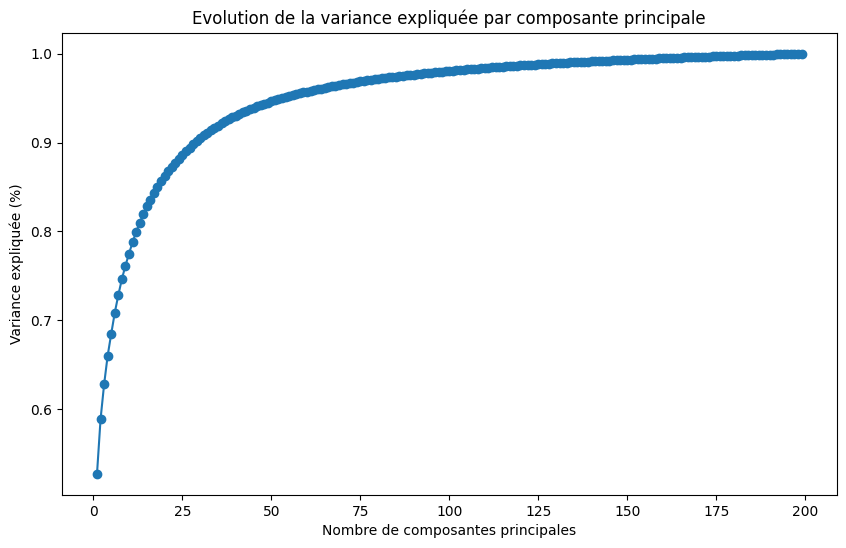

In [52]:
# Création tuple (composantes, variances) selon la table de variance expliquée
components, variances = zip(*explained_variance_table)

# Création du graphique de la variance expliquée
plt.figure(figsize=(10, 6))
plt.plot(components, variances, marker='o')

# Titres et labels
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée (%)')
plt.title('Evolution de la variance expliquée par composante principale')
plt.show()

### <span style='background:black'>d/Création du fichier csv</span>

Nous chargeons les données dans un DataFrame Pandas pour la visualiser plus facilement.

In [56]:
# Charger les résultats de l'ACP dans un DataFrame Pandas
df_result_pca = pd.read_parquet(PATH_Result_pca_parquet, engine='pyarrow')
display(df_result_pca.head())

,path,label,features,features_array,pca_features
0,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.85363054, 0.0, 0.0, 0.013514177, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.027579768, 0.0, 0.0, 0.0, 0.022468781,...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.070777185, 1.4807836, 0.0, 0.6048448, ...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85552573, 0.0...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,file:/content/drive/MyDrive/Colab Notebooks/P9...,Apple Golden 1,"[0.0, 0.075113416, 1.1581831, 0.0, 0.15176116,...","{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


Nous remarquons que les valeurs issues de l'ACP sont présentes dans un array qui est lui-même au sein du dictionnaire de la colonne 'pca_features'.

In [57]:
# Afficher les valeurs de la première ligne de la colonne pca_features
df_result_pca.loc[0, 'pca_features']['values']

array([ 5.94842616e+00,  1.93730400e+00,  1.95207803e+00, -4.18399155e+00,
        2.99983380e-01,  4.03392314e+00, -2.40879423e+00,  1.91679718e+00,
       -3.03547764e-01, -1.25225495e+00, -1.54774332e+00,  2.72998839e-01,
        4.46000853e+00,  5.63239320e-01, -6.25239668e+00,  2.11286351e+00,
        1.33078775e+00, -4.19919419e+00,  2.55003438e+00,  1.88669614e+00,
       -2.16435005e+00, -1.17374050e+00, -2.37491050e+00, -1.04921947e+00,
        2.21700736e+00,  3.36524623e-01, -2.25443226e-01,  1.18995294e+00,
       -4.65246418e+00,  2.03964266e+00,  1.05333989e+00, -1.49569465e+00,
       -1.56418393e+00, -1.29140163e+00,  2.74836515e+00,  1.35903584e+00,
       -1.46857731e+00,  2.52973474e-01,  1.26750373e+00, -1.64437292e+00,
       -1.08650115e+00,  4.45922892e-01,  1.01926113e+00, -4.33151906e+00,
        1.87468676e+00,  7.92763974e-01, -2.05090511e+00,  1.83165392e+00,
       -5.92647993e-01, -1.39596467e+00, -6.11443731e-01, -5.30946511e-04,
        2.45514661e+00, -

Nous créons une nouvelle colonne "values" qui contient ces valeurs et nous exportons le DataFrame en fichier csv.

In [58]:
# Creation d'une colonne 'values' contenant les valeurs des composantes
df_result_pca['values'] = df_result_pca['pca_features'].apply(
    lambda x: x['values']
)

# Convertion de la colonne 'values' en Series
values_df = df_result_pca['values'].apply(pd.Series)

# Création du chemin du fichier CSV
csv_path = os.path.join(PATH_Result_pca_csv, 'values_pca.csv')

# Export du dataframe en fichier CSV
values_df.to_csv(csv_path, index=False)

# Afficher un message de confirmation
print(f"Le DataFrame a été exporté avec succès en fichier CSV à l'emplacement suivant : {csv_path}")

Le DataFrame a été exporté avec succès en fichier CSV à l'emplacement suivant : /content/drive/MyDrive/Colab Notebooks/P9/results/pca_csv/values_pca.csv


Nous importons le fichier csv pour vérifier son contenu.

In [59]:
values_pca_df = pd.read_csv(csv_path)
display(values_pca_df)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,5.948426,1.937304,1.952078,-4.183992,0.299983,4.033923,-2.408794,1.916797,-0.303548,-1.252255,...,0.612769,-0.981549,0.304578,-0.221368,0.119753,0.709364,-0.891582,0.292179,0.511539,-0.587351
1,6.889805,-2.938021,2.774479,-4.523394,-3.493313,1.903728,-1.926276,1.203345,-1.895596,2.843716,...,0.495025,-0.872700,0.224073,0.076953,0.178136,0.683762,-0.527353,0.668368,0.292972,-0.726743
2,5.838755,-3.107682,3.698634,0.781728,-2.671344,0.915347,-4.814944,7.917844,-1.628792,2.176574,...,0.298835,-0.340981,0.203416,0.328447,0.322273,0.587298,-1.124373,0.358936,0.384174,-0.627194
3,4.372837,2.648197,-0.312655,-4.697694,1.977008,2.872904,-1.773527,1.250125,-0.173299,-1.097276,...,0.514013,-0.918187,0.214423,-0.070810,0.160188,0.486195,-0.853171,0.494484,0.400279,-0.582600
4,5.515550,-3.018866,3.212352,-0.487102,-2.756911,1.653380,-4.000662,7.620775,-0.980785,1.569843,...,0.449484,-0.820041,0.231595,0.128850,0.160119,0.695770,-0.584099,0.540758,0.370682,-0.842049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,-11.585310,1.094712,-4.552548,-3.807684,-6.870585,4.504005,-3.396758,3.226684,-0.056830,-0.965087,...,0.674135,-0.721349,0.122214,-0.061643,0.234972,0.596847,-0.623292,0.542470,0.270430,-0.832095
1396,-10.182086,-3.217234,-4.730998,-4.635059,-5.114324,3.907871,-4.411247,0.804968,0.115446,-1.152454,...,0.205178,-0.760680,0.165522,0.224469,0.297103,0.642713,-0.738409,0.762965,0.237550,-0.550547
1397,-12.341312,-4.365909,-4.191993,-4.611494,-4.141743,2.971279,-4.216865,1.506194,-1.758824,-1.527339,...,0.610879,-0.827471,0.209129,0.160546,0.267083,0.670455,-0.846169,0.695437,0.408120,-0.738311
1398,-10.818612,-3.599154,-4.356752,-4.427256,-4.224470,2.776668,-4.886353,2.310255,-0.612645,-1.345805,...,0.433490,-0.614106,0.153764,-0.021365,0.529251,0.500703,-0.514203,0.377897,0.566935,-0.645650


Ce fichier contient bien les valeurs des 200 premières composantes principales pour chacunes des 1_400 images.

## <span style='background:green'>4/Visualisation SparkUI</span>

Nous visualisons l'interface utilisateur de SparkUI pour vérifier les différentes étapes du traitement. Pour cela, nous utilisons la librairie "ngrok" pour exposer l'interface utilisateur de SparkUI sur un serveur distant.

In [60]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=4040
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://888955ff62c5:{port}\"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


 * ngrok tunnel "https://dace-34-83-159-31.ngrok-free.app" -> "http://888955ff62c5:4040"


<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier....<br>

# <span style='background:blue'>Etape 2 : Déploiement de la solution sur le cloud</span>

## <span style='background:green'>1/Choix du prestataire cloud : AWS</span>

Le prestataire le plus connu et qui offre à ce jour l'offre la plus large dans le cloud computing est **Amazon Web Services** (AWS).

Certaines de leurs offres sont parfaitement adaptées à notre problématique et c'est la raison pour laquelle nous utiliserons leurs services.

L'objectif premier est de pouvoir, grâce à AWS, <u>louer de la puissance de calcul à la demande</u>.
L'idée étant de pouvoir, quel que soit la charge de travail, obtenir suffisamment de puissance de calcul pour pouvoir traiter nos images, même si le volume de données venait à fortement augmenter.

De plus, la capacité d'utiliser cette puissance de calcul à la demande permet de diminuer drastiquement les coûts si l'on compare les coûts d'une location de serveur complet sur une durée fixe (1 mois, 1 année par exemple).

<img src="https://appmaster.io/api/_files/rr4hnsHMxxD3zRBqozjqSC/download/" width="500" height="250">


## <span style='background:green'>2/Choix de la solution technique : EMR</span>

<u>Plusieurs solutions s'offre à nous</u> :
1. Solution **IAAS** (Infrastructure AS A Service)
 - Dans cette configuration **AWS** met à notre disposition des serveurs vierges sur lequel nous avons un accès en administrateur, ils sont nommés **instance EC2**.<br />

   Nous pouvons avec cette solution reproduire pratiquement à l'identique la solution mis en œuvre en local sur notre machine.<br />
   <u>Nous installons nous-même l'intégralité des outils puis nous exécutons notre script</u> :
  - Installation de **Spark**, **Java** etc.
  - Installation de **Python** (via Anaconda par exemple)
  - Installation de **Jupyter Notebook**
  - Installation des **librairies complémentaires**
  - Il faudra bien évidement veiller à **implémenter les librairies nécessaires à toutes les machines (workers) du cluster**

  - <u>Avantages</u> :
      - Liberté totale de mise en œuvre de la solution
      - Facilité de mise en œuvre à partir d'un modèle qui s'exécute en local sur une machine Linux

  - <u>Inconvénients</u> :
      - Chronophage : nécessité d'installer et de configurer toute la solution
      - Possible problèmes techniques à l'installation des outils (propre aux serveurs EC2)
      - Mise à jour des outils et possible réinstallation de Spark, Java etc.

2. Solution **PAAS** (Plateforme As A Service)
 - **AWS** Cette offre permet de louer des **instances EC2**  avec des applications préinstallées et configurées : il s'agit du **service EMR**.
 - **Spark** y sera déjà installé
 - Possibilité de demander l'installation de **Tensorflow** ainsi que **JupyterHub**
 - Possibilité d'indiquer des **packages complémentaires** à installer à l'initialisation du serveur **sur l'ensemble des machines du cluster**.

 - <u>Avantages</u> :
     - Facilité de mise en œuvre : configuration simple pour obtenir un environnement parfaitement fonctionnel
     - Rapidité de mise en œuvre : Possibilité de recréer des clusters à l'identique disponibles presque instantanément (Intanciation en 15/20 minutes)
     - Solutions matérielles et logiciels optimisées par les ingénieurs d'AWS : versions installées fonctionnelles et architecture déjà optimisée
     - Stabilité de la solution
    - Solution évolutive : version à jour de chaque package à chaque nouvelle instanciation, compatibilité avec le reste de l’environnement garanti.
  - Plus sécurisé
	- Patchs de sécurité mis à jour à chaque nouvelle instanciation du cluster EMR.

 - <u>Inconvénients</u> :
     - Manque de liberté sur la version des packages disponibles
   

Nous utilisons la solution **PAAS** avec le service **EMR** d'Amazon Web Services qui permet une mise en oeuvre plus rapide et plus efficace que la solution IAAS pour notre problématique.

<img src="https://datascientest.com/wp-content/uploads/2023/05/amazon-amr-datascientest-1024x512.png" width="500" height="250">

## <span style='background:green'>3/Choix de la solution de stockage des données : Amazon S3</span>

### <span style='background:red'>MAJ a faire avec info de mon bucket</span>

<u>Amazon propose une solution très efficace pour la gestion du stockage des données</u> : **Amazon S3** (Simple Storage Service).

Les données stockées sur le serveur **EC2** <u>seront perdues</u> lorsque le serveur sera résilié pour limiter les coûts (si aucune sauvegarde n'est effectuée avant). Sans compter les problèmes de fonctionnement du serveur qui peuvent survenir si nous saturons son espace disque.

<u>Utiliser **Amazon S3** permet de s'affranchir de toutes ces problématiques</u>. L'espace disque disponible est **illimité**, et il est **indépendant de nos serveurs EC2**. L'accès aux données est **très rapide** car nous restons dans l'environnement d'AWS et nous prenons soin de <u>choisir la même région pour nos serveurs **EC2** et **S3**</u>.

De plus, <u>il est possible d'accéder aux données sur **S3** de la même manière que l'on **accède aux données sur un disque local**</u>. Nous utiliserons simplement un **PATH au format s3://...** .

<img src="https://miro.medium.com/v2/resize:fit:1400/0*aJ6BpnaRXbf01pEB.png" width="700" height="300">

## <span style='background:green'>4/Configuration de l'environnement de travail</span>

### <span style='background:black'>a/Création configuration IAM</span>

<u>La gestion des utilisateurs et de leurs droits s'effectue via le service **AMI**</u> d'AWS.

Nous y créons un utilisateur 'Pierrick' avec les droits administrateur (*AdministratorAccess*). Les autorisations minimales à donner sont :
- EC2FullAccess
- S3FullAccess
- EMRFullAccess

### <span style='background:black'>b/Configuration awscli</span>

### <span style='background:red'>A voir si besoin</span>

La première étape est d'installer et de configurer [**AWS Cli**](https://aws.amazon.com/fr/cli/), il s'agit de l'**interface en ligne de commande d'AWS**.<br />
Elle nous permet d'**interagir avec les différents services d'AWS**, comme **S3** par exemple.

Une fois l'utilisateur créé et ses autorisations configurées nous créons une **paire de clés** qui nous permettra de nous **connecter sans à avoir à devoir saisir systématiquement notre login/mot de passe**.

Il faut également configurer l'**accès SSH** à nos futurs serveurs EC2. Ici aussi, via un système de clés qui nous dispense de devoir nous authentifier "à la main" à chaque connexion.

### <span style='background:black'>c/Choix zone géographique des serveurs</span>

Nous choississons la zone géographique de nos serveurs **EC2** et **S3**. Il est important de choisir la même zone pour les deux services pour garantir une **communication rapide et efficace** entre les deux.

Nous choisissons la zone **eu-west-3** qui correspond à **Paris** pour être en conformité avec les **règles RGPD**.

## <span style='background:green'>5/Upload de nos données sur S3</span>

Nous n'utilisons que les données contenues dans le dossier **Test** du [jeu de données du projet](https://www.kaggle.com/moltean/fruits/download). Pour cela, nous isolons ce dossier dans un dossier "dossier_sync_AWS_S3" sur notre machine locale.

La première étape consiste à **créer un bucket sur S3** :
- **aws s3 mb s3://pb-ocr-p9**

Nous copions ensuite le contenu du dossier "**dossier_sync_AWS_S3**" sur notre bucket "**pb-ocr-p9**":
1. On se place à l'intérieur du répertoire **dossier_sync_AWS_S3**
2. **aws sync . s3://pb-ocr-p9**

La commande **sync** est utile pour synchroniser deux répertoires. Ainsi, le dossier "dossier_sync_AWS_S3" est copié dans le bucket "pb-ocr-p9". Nous y trouvons un dossier "Test" avec les 22_688 images de fruits.

<u>Nos données du projet sont maintenant disponibles sur Amazon S3</u>.


## <span style='background:green'>6/Configuration du serveur EMR</span>

### <span style='background:black'>a/Configuration framework et logiciels</span>

<u>Paramétrez la persistance des notebooks créés et ouvert via JupyterHub</u> :
- On peut à cette étape effectuer des demandes de paramétrage particulières sur nos applications. L'objectif est, comme pour le reste de nos données de travail, d'éviter toutes les problématiques évoquées précédemment. C'est l'objectif à cette étape, <u>nous allons enregistrer et ouvrir les notebooks</u> non pas sur l'espace disque de  l'instance EC2 (comme ce serait le cas dans la configuration par défaut de JupyterHub) mais <u>directement sur **Amazon S3**</u>. deux solutions sont possibles pour réaliser cela :
 1. Créer un **fichier de configuration JSON** que l'on **upload sur S3** et on indique ensuite le chemin d’accès au fichier JSON
 2. Rentrez directement la configuration au format JSON
 
Nous optons pour la création d'un fichier JSON lors de la création de notre première instance EMR, puis lorsque nous clonerons notre serveur pour en recréer un facilement à l'identique, la configuration du fichier JSON sera directement copié.

<u>Voici le contenu de mon fichier JSON</u> :  [{"classification":"jupyter-s3-conf","properties":{"s3.persistence.bucket":"pb-ocr-p9","s3.persistence.enabled":"true"}}]

### <span style='background:black'>b/Matériel</span>

A cette étape, laissez les choix par défaut. <u>L'important ici est la sélection de nos instances</u> :

1. je choisi les instances de type **M5** qui sont des **instances de type équilibrés**
2. je choisi le type **xlarge** qui est l'instance la **moins onéreuse disponible**
3. Je sélectionne **1 instance Maître** (le driver) et **2 instances Principales** (les workeurs) soit **un total de 3 instance EC2**.

### <span style='background:black'>c/Paramètres de cluster généraux</span>

#### <u>Options générales</u>
La première chose à faire est de donner un nom au cluster : <u>P9_fruits</u> 

*Nous avons également décoché "Protection de la résiliation" pour des raisons pratiques.*

#### <u>Actions d'amorçage</u>

Nous allons à cette étape **choisir les packages manquants à installer** et qui 
nous serons utiles dans l'exécution de notre notebook.<u>L'avantage de réaliser cette étape maintenant est que les packages installés le seront sur l'ensemble des machines du cluster</u>.

Nous créons donc un fichier nommé "**bootstrap-emr.sh**" que nous <u>uploadons 
sur S3</u> (à la racine de mon **bucket "pb-ocr-p9"**) et nous l'ajoutons à la liste des actions d'amorçage.

Voici le contenu du fichier **bootstrap-emr.sh**

```bash	
sudo python3 -m pip install -U setuptools
sudo python3 -m pip install -U pip
sudo python3 -m pip install wheel pillow pandas tensorflow pyarrow boto3 s3fs fsspec
```

### <span style='background:black'>d/Sécurité</span>

A cette étape nous sélectionnons la **paire de clés EC2** créé précédemment. Elle nous permettra de se connecter en **ssh** à nos **instances EC2** sans avoir à entrer nos login/mot de passe.Nous laissons les autres paramètres par défaut.


## <span style='background:green'>7/Intanciation du serveur</span>

Il ne nous reste plus qu'à attendre que le serveur soit prêt. Cette étape peut prendre entre **15 et 20 minutes**.

## <span style='background:green'>8/Création du tunnel SSH à l'instance EC2 (Maître)</span>

### <span style='background:black'>a/Création des autorisations sur les connexions entrantes</span>

<u>Nous souhaitons maintenant pouvoir accéder à nos applications</u> :
 - **JupyterHub** pour l'exécution de notre notebook
 - **Serveur d'historique Spark** pour le suivi de l'exécution des tâches de notre script lorsqu'il sera lancé
 
Cependant, <u>ces applications ne sont accessibles que depuis le réseau local du driver</u>, et pour y accéder nous devons **créer un tunnel SSH vers le driver**.

Par défaut, ce driver se situe derrière un firewall qui bloque l'accès en SSH. <u>Pour ouvrir le port 22 qui correspond au port sur lequel écoute le serveur SSH, il faut modifier le **groupe de sécurité EC2 du driver**</u>.

### <span style='background:black'>b/Création du tunnel ssh vers le Driver</span>

Nous pouvons désormais établir le **tunnel SSH** vers le **Driver**. Pour cela nous récupèrons les informations de connexion fournis par Amazon depuis la page du service EMR / Cluster / onglet Récapitulatif en cliquant sur "**Activer la connexion Web**"

### <span style='background:red'>MAJ a faire</span>

Nous choisissons d'utiliser le port **5555** au lieu du **8157**, même si le choix n'est pas très important.    j'ai également rencontré un <u>problème de compatibilité</u> avec l'argument "**-N**". Nous le supprimons.

<u>Finalement, j'utilise la commande suivante dans un terminal pour établir mon tunnel ssh (seul l'URL change d'une instance à une autre)</u> : "**ssh -i ~/.ssh/p8-ec2.pem -D 5555 hadoop@ec2-35-180-91-39.eu-west-3.compute.amazonaws.com**"

<u>On inscrit "**yes**" pour valider la connexion et si la connexion est établit on obtient le résultat suivant</u> :

Nous avons **correctement établi le tunnel ssh avec le driver** sur le port "5555".

### <span style='background:black'>c/Configuration de FoxyProxy</span>

Une dernière étape est nécessaire pour accéder à nos applications, en demandant à notre navigateur d'emprunter le tunnel ssh. J'utilise pour cela **FoxyProxy**.

Sinon, ouvrez la configuration de **FoxyProxy** et <u>cliquez sur **Ajouter**</u> en haut à gauche puis renseigner les éléments comme dans la capture ci-dessous :

### <span style='background:black'>d/Accès aux applications du serveur EMR via le tunnel ssh</span>

Nous activons le **tunnel ssh** comme vu précédemment puis nous demandons à notre navigateur de l'utiliser avec **FoxyProxy**. Nous pouvons désormais accéder à plusieurs applications.

## <span style='background:green'>9/Connexion au notebook JupyterHub</span>

Pour se connecter à **JupyterHub** en vue d'exécuter notre **notebook**, il faut commencer par <u>cliquer sur l'application **JupyterHub**</u> apparu depuis que nous avons configuré le **tunnel ssh** et **foxyproxy** sur notre navigateur (actualisez la page si ce n’est pas le cas).

### <span style='background:red'>MAJ a faire</span>

Nous nous connectons avec les informations par défaut :
 - <u>login</u>: **jovyan**
 - <u>password</u>: **jupyter**

Grace à la **persistance** paramétrée à l'instanciation du cluster nous sommes actuellement dans l'arborescence de notre **bucket S3**

Je décide d'**importer un notebook déjà rédigé en local directement sur S3** et je l'ouvre depuis **l'interface JupyterHub**.

## <span style='background:green'>10/Exécution du code</span>

Nous décidons d'exécuter cette partie du code depuis **JupyterHub hébergé sur notre cluster EMR**. Pour ne pas alourdir inutilement les explications du **notebook**, nous ne réexpliquerons pas les étapes communes que nous avons déjà vues dans la première partie lors de l'éxécution locale.

<u>Avant de commencer</u>, il faut s'assurer d'utiliser le **kernel pyspark**.

**En utilisant ce kernel, une session spark est créé à l'exécution de la première cellule**. Il n'est donc **plus nécessaire d'exécuter le code "spark = (SparkSession ..."** comme lors de l'exécution de notre notebook en local sur notre VM Ubuntu.

In [ ]:
# L'exécution de cette cellule démarre l'application Spark

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [ ]:
%%info

<u>Installation des packages</u>

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

<u>Import des librairies</u>

In [ ]:
# Librairies generales
import os
import os.path
import sys
import time
from datetime import datetime

# Librairies data science
import pandas as pd
from PIL import Image
import numpy as np
import io
import matplotlib as mpl
import matplotlib.pyplot as plt

# Librairies TensorFlow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Librairies Spark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")

print("Version des librairies utilisées :")
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.__version__)
print("Pandas        : " + pd.__version__)
print("Pillow (Image): " + Image.__version__)
print("Tensorflow    : " + tf.__version__)
print("PySpark       : " + SparkSession.builder.getOrCreate().version)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

<u>Fonction</u>

In [ ]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée d'éxécution du notebook.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """
    # Calculer la durée totale et convertir en minutes et secondes
    minutes, seconds = divmod(time.time() - start_time, 60)

    # Afficher la durée totale
    print(f"Durée execution notebook : {int(minutes)} min {int(seconds)} sec")

In [ ]:
def calculer_variance_expliquee(model_fitted, nbr_composante, modulo=20):
    """
    Cette fonction calcule la variance totale et la variance cumulative
    expliquée par chaque composante principale.
    Elle imprime la variance expliquée pour chaque multiple de x composantes.

    :param model_fitted: Le modèle PCA ajusté.
    :param nbr_composante: Le nombre total de composantes principales.
    :param modulo : le nombre du modulo pour print les variances expliquées
    :return: Une liste de tuples, où chaque tuple contient le nombre de
    composantes et la variance cumulative expliquée.
    """
    # Calculer la variance totale
    total_variance = sum(model_fitted.explainedVariance)
    print("Variance Totale: ", round(total_variance, 3))

    # Calculer la somme cumulative des variances expliquées
    cumulative_variance = np.cumsum(model_fitted.explainedVariance)

    # Créer table de la variance expliquée pour chaque ensemble de composantes
    explained_variance_table = []
    for i in range(1, nbr_composante, 1):
        explained_variance = cumulative_variance[i] / total_variance
        explained_variance_table.append((i, explained_variance))

        # print que les multiples du modulo
        if i % modulo == 0:
            print(
                f"Variance expliquée avec {i} composantes: {explained_variance:.3f}"
            )

    return explained_variance_table

<u>Définition des PATH pour charger les images et enregistrer les résultats</u>

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [ ]:
# Afficher le répertoire de travail actuel
print("Current directory :", os.getcwd())

# Définir le répertoire de travail
PATH = 's3://pb-ocr-p9'

# Création des noms des répertoires
PATH_Data = PATH + '/Test'
PATH_Result = PATH + '/Results'
PATH_Result_features = PATH_Result + '/features_parquet'
PATH_Result_pca_parquet = PATH_Result + '/pca_parquet'
PATH_Result_pca_csv = PATH_Result + '/pca_csv'

# Liste des répertoires
paths = [
    PATH_Data,
    PATH_Result,
    PATH_Result_features,
    PATH_Result_pca_parquet,
    PATH_Result_pca_csv
]

# Création des répertoires s'ils n'existent pas
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

# Afficher les répertoires
print(
    'PATH:        ' + PATH +\
    '\nPATH_Data:   ' + PATH_Data +\
    '\nPATH_Result:   ' + PATH_Result +\
    '\nPATH_Result_features: '+ PATH_Result_features +\
    '\nPATH_Result_pca_parquet: '+ PATH_Result_pca_parquet +\
    '\nPATH_Result_pca_csv: '+ PATH_Result_pca_csv
)

<u>Chargement des données</u>

In [ ]:
# Charger les images dans un DataFrame Spark
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(PATH_Data)

# Ajout de la col label à partir du nom du dernier dossier contenant l'image
images = images.withColumn('label', element_at(split(images['path'], '/'), -2))

# Afficher le schema et les 5 premières lignes
print("Voici le schema du DataFrame :")
print(images.printSchema())

print("Voici les 5 premières lignes du DataFrame :")
print(images.show(5))

print("Nombre de lignes/image dans le DataFrame : ", images.count())

<u>Préparation du modèle</u>

In [ ]:
model = MobileNetV2(
    weights='imagenet',
    include_top=True,
    input_shape=(224, 224, 3)
)

In [ ]:
new_model = Model(
    inputs=model.input,
    outputs=model.layers[-2].output
)

In [ ]:
broadcast_weights = sc.broadcast(new_model.get_weights())

In [ ]:
new_model.summary()

<u>Fonctions pour traitement des données</u>

In [ ]:
def model_fn():
    """
    Cette fonction crée un modèle MobileNetV2 avec des poids pré-entraînés à partir d'ImageNet, retire la couche supérieure du modèle, rend toutes les couches non entraînables (c'est-à-dire, leurs poids ne seront pas mis à jour pendant l'entraînement), puis définit les poids du nouveau modèle à partir d'une valeur diffusée.

    :return: Le nouveau modèle avec les poids pré-entraînés diffusés.
    """
    # Créer modèle MobileNetV2 avec des poids pré-entraînés à partir d'ImageNet
    model = MobileNetV2(
        weights='imagenet',
        include_top=True,
        input_shape=(224, 224, 3)
    )

    # Rendre les couches non entraînables
    for layer in model.layers:
        layer.trainable = False

    # création nouveau modèle sans la dernière couche
    new_model = Model(
        inputs=model.input,
        outputs=model.layers[-2].output
    )

    # transmettre les poids du modèle
    new_model.set_weights(broadcast_weights.value)
    print("Broadcast des poids du modèle effectué")

    return new_model

In [ ]:
def preprocess(content):
    """
    Cette fonction charge une image à partir des données brutes, redimensionne
    l'image à une taille de 224x224 pixels, la convertit en un tableau numpy,
    puis applique la fonction de prétraitement de MobileNetV2.

    :param content: Les données brutes de l'image à prétraiter.

    :return: Le tableau numpy de l'image prétraitée.
    """
    # Chargement de l'image et redimensionnement à 224x224
    img = Image.open(io.BytesIO(content)).resize([224, 224])

    # Conversion en tableau numpy
    arr = img_to_array(img)

    # Application de la fonction preprocess_input de MobileNetV2
    return preprocess_input(arr)

In [ ]:
def featurize_series(model, content_series):
    """
    Effectue une caractérisation (featurization) d'une pd.Series d'images
    brutes en utilisant le modèle en entrée.

    :param model: Un modèle de deep learning pré-entraîné pour la
    caractérisation des images.
    :param content_series: Une pd.Series contenant des images brutes à
    caractériser.

    :return: Une pd.Series où chaque élément est un vecteur unidimensionnel
    de caractéristiques d'image.
    """
    # Application prétraitement à chaque image brute et empilement dans array
    input = np.stack(content_series.map(preprocess))

    # Utilisation du modèle pour prédire les caractéristiques de l'image
    preds = model.predict(input)

    # Applatissement des caractéristiques en 1 vecteur 1D (besoin pour Spark)
    output = [p.flatten() for p in preds]

    # Conversion en pd.Series
    return pd.Series(output)

In [ ]:
# Decorateur pour définir une UDF pandas de type Scalar Iterator
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)

def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF pandas de type Scalar Iterator qui enveloppe
    notre fonction de featurisation. Le décorateur spécifie qu'elle renvoie
    une colonne de DataFrame Spark de type ArrayType(FloatType).

    :param content_series_iter: Cet argument est un itérateur sur des lots de
    données, où chaque lot est une série pandas de données d'image.
    '''
    # Charger le modèle une fois  (réutiliser pour plusieurs lots de données)
    model = model_fn()

    # POUR chaque lot de données
    for content_series in content_series_iter:
        print("Lot de données de taille : ", content_series.shape)

        # Application de la fonction de featurisation (du modele sur le lot)
        yield featurize_series(model, content_series)

<u>Extraction des features</u>

In [ ]:
# 20 partitions + select col path & label + featurize & rename col content
features_df = images.repartition(20).select(
    col("path"),
    col("label"),
    featurize_udf("content").alias("features")
)
print("\nFeatures calculées")

<u>Sauvegarde des features</u>

In [ ]:
# Sauvegarde des features en format Parquet
features_df.write.mode("overwrite").parquet(PATH_Result_features)
print(
    f"Save des features effectuée dans le chemin : {PATH_Result_features}"
)

<u>Chargement des données enregistrées et validation des résultats</u>

In [ ]:
features_pandas_df = pd.read_parquet(PATH_Result_features, engine='pyarrow')
display(features_pandas_df)

Nous vérifions qu'il a a bien 1_280 features pour chaque image (output de la dernière couche du modèle).

In [ ]:
features_pandas_df.loc[0,'features'].shape

In [ ]:
features_pandas_df.shape

<u>Encapsulation des features dans un array</u>

In [ ]:
# Fonction udf pour transformer un array en VectorUDT
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Ajouter une colonne de features_array
features_df = features_df.withColumn(
    "features_array", array_to_vector_udf(col("features"))
)

# Afficher le dataframe
features_df.show()

<u>Réduction de dimension ACP</u>

In [ ]:
# Nombre de composantes de l'ACP
nbr_composante = 200

# Créer un objet PCA, entrainement et transformation
pca = PCA(
    k=nbr_composante,
    inputCol="features_array",
    outputCol="pca_features"
)
model_fitted = pca.fit(features_df)
pca_result_df = model_fitted.transform(features_df)

# Calculer la variance totale et la variance cumulative expliquée
explained_variance_table = calculer_variance_expliquee(
    model_fitted,
    nbr_composante
)

# Enregistrer les résultats de l'ACP en format parquet
pca_result_df.write.mode('overwrite').parquet(PATH_Result_pca_parquet)
print("\nLes résultats de l'ACP ont été sauvegardés")

# Afficher les dimensions du dataframe des résultats de l'ACP
print("Number of rows: ", pca_result_df.count())
print("Number of columns: ", len(pca_result_df.columns))
print(pca_result_df.columns)

<u>Plot évolution variance selon ACP</u>

In [ ]:
# Création tuple (composantes, variances) selon la table de variance expliquée
components, variances = zip(*explained_variance_table)

# Création du graphique de la variance expliquée
plt.figure(figsize=(10, 6))
plt.plot(components, variances, marker='o')

# Titres et labels
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée (%)')
plt.title('Evolution de la variance expliquée par composante principale')
plt.show()

<u>Création fichier csv</u>

In [ ]:
# Charger les résultats de l'ACP dans un DataFrame Pandas
df_result_pca = pd.read_parquet(PATH_Result_pca_parquet, engine='pyarrow')
display(df_result_pca.head())

In [ ]:
# Afficher les valeurs de la première ligne de la colonne pca_features
df_result_pca.loc[0, 'pca_features']['values']

In [ ]:
# Creation d'une colonne 'values' contenant les valeurs des composantes
df_result_pca['values'] = df_result_pca['pca_features'].apply(
    lambda x: x['values']
)

# Convertion de la colonne 'values' en Series
values_df = df_result_pca['values'].apply(pd.Series)

# Création du chemin du fichier CSV
csv_path = os.path.join(PATH_Result_pca_csv, 'values_pca.csv')

# Export du dataframe en fichier CSV
values_df.to_csv(csv_path, index=False)

# Afficher un message de confirmation
print(
    f"Le df a été exporté en fichier CSV à l'emplacement suivant : {csv_path}"
)

<u>Vérification fichier csv</u>

In [ ]:
values_pca_df = pd.read_csv(csv_path)
display(values_pca_df)

## <span style='background:green'>11/Suivi de l'avancement des tâches avec le Serveur d'Historique Spark</span>

Grâce au **tunnel ssh** et à **FoxyProxy**, nous pouvons accéder au **Serveur d'Historique Spark**. Nous pouvons ainsi suivre l'avancement des tâches lancées par notre script.

#### <span style='background:red'>MAJ à faire</span>

Nous constatons que notre cluster de calcul a mis  **moins de 8 minutes** pour traiter les **22_688 images**.

## <span style='background:green'>12/Résiliation de l'instance EMR</span>

Notre travail est maintenant terminé.

Le cluster de machines EMR est **facturé à la demande**, et nous continuons d'être facturé même lorsque <br />
les machines sont au repos. Pour **optimiser la facturation**, il nous faut maintenant **résilier le cluster**.

## <span style='background:green'>13/Cloner le serveur EMR (si besoin)</span>

Si nous devons de nouveau exécuter notre notebook dans les mêmes conditions, il nous suffit de **cloner notre cluster** et ainsi en obtenir une copie fonctionnelle sous 15/20 minutes, le temps de son instanciation.

## <span style='background:green'>14/Arborescence du serveur S3 à la fin du projet</span>

<u>Pour information, voici **l'arborescence complète de mon bucket S3 pb-ocr-p9** à la fin du projet</u> : <br />
*Par soucis de lisibilité, nous ne listons pas les 131 sous dossiers du répertoire "Test"*

#### <span style='background:red'>MAJ à faire</span>

1. Results/_SUCCESS
2. Results/part-00000-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
3. Results/part-00001-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
4. Results/part-00002-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
5. Results/part-00003-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
6. Results/part-00004-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
7. Results/part-00005-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
8. Results/part-00006-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
9. Results/part-00007-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
10. Results/part-00008-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
11. Results/part-00009-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
12. Results/part-00010-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00011-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
1. Results/part-00012-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
2. Results/part-00013-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
3. Results/part-00014-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
4. Results/part-00015-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
5. Results/part-00016-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
6. Results/part-00017-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
7. Results/part-00018-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
8. Results/part-00019-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
9. Results/part-00020-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
10. Results/part-00021-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
11. Results/part-00022-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
12. Results/part-00023-2cc36f38-19ef-4d8a-a0d1-5ddb309b3894-c000.snappy.parquet
13. Test/
14. bootstrap-emr.sh
15. jupyter-s3-conf.json
16. jupyter/jovyan/.s3keep
17. jupyter/jovyan/P8_01_Notebook.ipynb
18. jupyter/jovyan/_metadata
19. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/
1. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/file-perm.sqlite
1. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/nbconvert/
2. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/nbconvert/templates/
3. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/nbconvert/templates/html/
4. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/nbconvert/templates/latex/
5. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/nbsignatures.db
6. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.aws-editors-workspace-metadata/notebook_secret
7. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.ipynb_checkpoints/
8. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.ipynb_checkpoints/Untitled-checkpoint.ipynb
9. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.ipynb_checkpoints/Untitled1-checkpoint.ipynb
10. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/.ipynb_checkpoints/test3-checkpoint.ipynb
11. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/Untitled.ipynb
12. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/Untitled1.ipynb
13. jupyter/jovyan/e-5OTY4VKPDT21945FF6DN15E35/test3.ipynb


# <span style='background:blue'>Conclusion</span>

Ici

In [61]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée execution notebook : 12 min 42 sec


**Sélectionner les outils du Cloud permettant de traiter et stocker les données d'un projet Big Data conforme aux normes RGPD en vigueur afin de concevoir une application de qualité supportant le traitement de données massives.**
- CE1 Le candidat a identifié les différentes briques d'architecture nécessaires pour la mise en place
d'un environnement Big Data.
- CE2 Le candidat a identifié les outils du cloud permettant de mettre en place l'environnement Big Data
conforme aux normes RGPD en vigueur.

**Prétraiter, analyser et modéliser des données (en veillant à leur conformité RGPD) dans un environnement Big Data et en utilisant les outils du Cloud afin de concevoir une application sécurisée de qualité supportant le traitement de données massives.**
- ~~CE1 Le candidat a chargé les fichiers de départ et ceux après transformation dans un espace de stockage cloud conforme à la réglementation RGPD.~~
- CE2 Le candidat a exécuté les scripts en utilisant des machines dans le cloud.
- CE3 Le candidat a réalisé un script qui permet d'écrire les sorties du programme directement dans l'espace de stockage cloud.

**Réaliser des calculs distribués sur des données massives en utilisant les outils adaptés et en prenant en compte le RGPD afin de permettre la mise en oeuvre d’applications à l’échelle.**
- CE1 Le candidat a identifié les traitements critiques lors d'un passage à l'échelle en termes de volume de données.
- ~~CE2 Le candidat veille à ce que l’exploitation des données soit conforme au RGPD. Dans le cadre de ce projet :~~
    - ~~les données sont stockées, et les traitements sont réalisés, sur des serveurs situés sur le territoire européen~~
- CE3 Le candidat a développé les scripts s’appuyant sur Spark.
- CE4 Le candidat s'est assuré que toute la chaîne de traitement est exécutée dans le cloud.